# Ensemble Strategy

## Imports

In [17]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
from tabulate import tabulate
sys.path.append("../")
sys.path.append("../FinRL")

import pandas as pd 
import numpy as np
import datetime
from copy import deepcopy
import pyfolio as pf
from pyfolio import timeseries
import matplotlib.pyplot as plt
import empyrical
import seaborn as sns
from quantrocket.zipline import ZiplineBacktestResult
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from scipy import interpolate
%matplotlib inline

In [18]:
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.agents.stablebaselines3.models import DRLEnsembleAgent
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

In [19]:
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3 import SAC

In [20]:
from matplotlib.ticker import FuncFormatter
import empyrical as ep

In [21]:
from finrl.config import (
    TRAINED_MODEL_DIR,
    RESULTS_DIR
)

from finrl.config_tickers import DOW_30_TICKER

from Config.local_config import (
    TRAIN_START_DATE,
    TRAIN_END_DATE,

    TRADE_START_DATE,
    TRADE_END_DATE
)

import Config.model_kwargs_config as model_kwargs

In [22]:
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}
NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise
}

In [23]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [24]:
plt.rcParams.update({'font.size': 16})

## Strategy Implementation 

In [25]:
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

In [26]:
class model_parameters:
    def __init__(self, model_name, kwargs, steps, data, data_retention_level):
        self.model_name = model_name
        self.model = None
        self.sharpe = []
        self.kwargs = kwargs
        self.policy = "MlpPolicy"
        self.policy_kwargs = None
        self.verbose = 0
        self.total_timesteps = steps
        self.data = data
        self.data_retention_level = data_retention_level

In [36]:
class account:
    def __init__(self, balance, stock_dimension, turbulence_threshold, stocks_held = None):
        self.balance = balance
        self.hmax = 100
        self.buy_cost = 0.001
        self.sell_cost = 0.001
        self.stock_dimension = stock_dimension
        self.turbulence_threshold = turbulence_threshold
        if stocks_held == None:
            self.num_of_stocks = [0] * stock_dimension
        else:
            self.num_of_stocks = stocks_held

In [277]:
class train_base_models():
    def __init__(self, start_trade, end_trade, algorithms):
        self.start_trade = start_trade
        self.end_trade = end_trade
        self.algorithms = algorithms

        self.account = account(1000000, 29, 30)

        self.results = []
    
    def run_base_models(self):
        
        for model_params in self.algorithms:
            training_env, e_trade_gym = self.create_environments(model_params.data)
            print(f"Training {model_params.model_name}_{model_params.data_retention_level}")
            trained_model = self.train_algorithm(training_env, model_params)
            model_params.model = trained_model
            df_account_value, df_actions  = self.trade_algorithm(e_trade_gym, trained_model)
            self.results.append(df_account_value)
        
        return self.results
            

    # ============
    #  Train 
    # ============
    def train_algorithm(self, training_env, model_params):
        with suppress_stdout():
            agent = DRLAgent(env = training_env)
            model = agent.get_model(
                model_params.model_name,
                policy = model_params.policy,
                policy_kwargs = model_params.policy_kwargs,
                model_kwargs = model_params.kwargs
            )
            trained_model = agent.train_model(model = model, tb_log_name = model_params.model_name, total_timesteps = model_params.total_timesteps)

        return trained_model
            

    # ============
    #  Trade 
    # ============
    def trade_algorithm(self, e_trade_env, trained_model):
        with suppress_stdout():
            df_account_value, df_actions, _ = DRLAgent.DRL_prediction(
                model = trained_model, 
                environment = e_trade_env
            )

        return df_account_value, df_actions 

    # ============
    #  Create Environments
    # ============
    def create_environments(self, data):
        train_data = data_split(
            data, 
            start = data['date'][0], 
            end = self.start_trade
        )
        
        trade_data = data_split(
            data,
            start = self.start_trade,
            end = self.end_trade,
        )

        kwargs = {
            'hmax': self.account.hmax,
            "initial_amount": self.account.balance,
            "num_stock_shares": [0] * self.account.stock_dimension,
            "buy_cost_pct": [self.account.buy_cost] * self.account.stock_dimension,
            "sell_cost_pct": [self.account.sell_cost] * self.account.stock_dimension,
            "state_space": 1 + 2 * self.account.stock_dimension + len(train_data.columns[7:-2]) * self.account.stock_dimension,
            "stock_dim": self.account.stock_dimension,
            "tech_indicator_list": train_data.columns[7:-2],
            "action_space": self.account.stock_dimension,
            "reward_scaling": 1e-4
        }

        e_train_gym = StockTradingEnv(df = train_data, **kwargs)
        e_trade_gym = StockTradingEnv(df = trade_data, turbulence_threshold = self.account.turbulence_threshold, risk_indicator_col='vix', **kwargs)

        training_env, _ = e_train_gym.get_sb_env()

        return training_env, e_trade_gym

In [278]:
class ensemble_strategy2():
    def __init__(self, trade_start, trade_end, algorithms, rebalance_time, account_in = None):
        self.trade_start = trade_start
        self.trade_end = trade_end
        self.algorithms = algorithms
        self.rebalance_time = rebalance_time

        unique_train_date = algorithms[0].data[
            (algorithms[0].data.date < trade_start)
        ].date.unique()
        self.unique_trade_date = algorithms[0].data[
            (algorithms[0].data.date > trade_start) & (algorithms[0].data.date <= trade_end)
        ].date.unique()
        
        self.unique_trade_date = np.insert(self.unique_trade_date, 0, unique_train_date[-rebalance_time:])

        if account_in == None:
            self.account = account(1000000, 29, 30)
        else:
            self.account = account_in

        self.account_value = pd.DataFrame()
        self.actions = pd.DataFrame()
        self.states = pd.DataFrame()

        self.validation_start_date_list = []
        self.validation_end_date_list = []
        self.iteration_list = []
        self.models_used = []
        self.breaks = False

    # ============
    #  Run Strategy
    # ============
    def run_strategy(self):
        for i in range(self.rebalance_time*2, len(self.unique_trade_date)+self.rebalance_time, self.rebalance_time):
            if i > len(self.unique_trade_date):
                i = len(self.unique_trade_date)
                self.breaks = True
            
            self.iteration_list.append(i)

            self.validation_start_date_list.append(self.unique_trade_date[i - (self.rebalance_time * 2)])
            self.validation_end_date_list.append(self.unique_trade_date[i - self.rebalance_time])

            for model_params in self.algorithms:
                training_env, e_val_gym = self.create_environments(i, model_params.data)

                print(f"Training {model_params.model_name}_{model_params.data_retention_level}_{i}")

                trained_model = self.train_algorithm(training_env, model_params)
                model_params.model = trained_model
                model_params.sharpe.append(self.val_algorithm(e_val_gym, trained_model))
            
            best_model, best_model_name = self.get_best_model()
            self.models_used.append(f"{str(best_model_name)}_{best_model.data_retention_level}")
            best_model.model.save("extra_models/" + best_model_name + "_" + str(i))

            e_trade_gym = self.create_trade_environment(i, best_model.data)

            df_account_value, df_actions, state = self.trade_algorithm(best_model.model, e_trade_gym)

            self.account_value = pd.concat([self.account_value, df_account_value])
            self.actions = pd.concat([self.actions, df_actions])

            self.account.balance = state[-1][0]
            self.account.num_of_stocks = state[-1][30:59]

            if(self.breaks == True):
                break
        
        summary = pd.DataFrame(
            [
                self.iteration_list,
                self.validation_start_date_list,
                self.validation_end_date_list,
                self.models_used
            ]
        ).T
        
        summary.columns = [
            "Iter",
            "Val Start",
            "Val End",
            "Model Used"
        ]
        
        for alg in self.algorithms:
            # print(f"{alg.model_name}:{alg.sharpe}")
            summary[f"{alg.model_name}_{model_params.data_retention_level} Sharpe"] = alg.sharpe
        
        self.account_value = self.account_value.reset_index(drop=True)
        self.actions.to_csv("Results/CSV/actions.csv")
        self.account_value.to_csv("Results/CSV/account_value.csv")
        summary.to_csv("Results/CSV/summery.csv")

        return summary
        
            

    # ============
    #  Training
    # ============
    def train_algorithm(self, training_env, model_params):
        with suppress_stdout():
            agent = DRLAgent(env = training_env)
            kwargs = deepcopy(model_params.kwargs)
            model = agent.get_model(
                model_params.model_name,
                policy = model_params.policy,
                policy_kwargs = model_params.policy_kwargs,
                model_kwargs = kwargs
            )
            trained_model = agent.train_model(model = model, tb_log_name = model_params.model_name, total_timesteps = model_params.total_timesteps)

        return trained_model
    
    # ============
    #  Validation
    # ============
    def val_algorithm(self, e_val_env, trained_model):
        with suppress_stdout():
            df_account_value, df_actions, _ = DRLAgent.DRL_prediction(
                model = trained_model, 
                environment = e_val_env
            )

        df = deepcopy(df_account_value)
        df["date"] = pd.to_datetime(df["date"])
        bt_returns = get_daily_return(df, value_col_name="account_value")

        return empyrical.sharpe_ratio(bt_returns)
    
    def get_best_model(self):
        best_model_sharpe = float('-inf')
        for model in self.algorithms:
            if model.sharpe[-1] > best_model_sharpe:
                best_model_sharpe = model.sharpe[-1]
                best_model = model
                best_model_name = model.model_name
        
        return best_model, best_model_name

    # ============
    #  Trading
    # ============
    def trade_algorithm(self, best_model, e_trade_env):
        with suppress_stdout():
            df_account_value, df_actions, state = DRLAgent.DRL_prediction(
                model = best_model, 
                environment = e_trade_env
            )

        return df_account_value, df_actions, state

    # ============
    #  Create Environments
    # ============
    def create_environments(self, unique_trade_date_counter, data):
        train_data = data_split(
            data, 
            start = data['date'][0],
            end = self.unique_trade_date[unique_trade_date_counter - (self.rebalance_time*2)]
        )
        val_data = data_split(
            data,
            start = self.unique_trade_date[unique_trade_date_counter - (self.rebalance_time * 2)],
            end = self.unique_trade_date[unique_trade_date_counter - self.rebalance_time],
        )
        
        kwargs = {
            'hmax': self.account.hmax,
            "initial_amount": self.account.balance,
            "num_stock_shares": self.account.num_of_stocks,
            "buy_cost_pct": [self.account.buy_cost] * self.account.stock_dimension,
            "sell_cost_pct": [self.account.sell_cost] * self.account.stock_dimension,
            "state_space": 1 + 2 * self.account.stock_dimension + len(val_data.columns[7:-2]) * self.account.stock_dimension,
            "stock_dim": self.account.stock_dimension,
            "tech_indicator_list": val_data.columns[7:-2],
            "action_space": self.account.stock_dimension,
            "reward_scaling": 1e-4
        }

        e_train_gym = StockTradingEnv(df = train_data, **kwargs)
        e_val_gym = StockTradingEnv(df = val_data, turbulence_threshold = self.account.turbulence_threshold, risk_indicator_col='vix', **kwargs)
        
        training_env, _ = e_train_gym.get_sb_env()

        return training_env, e_val_gym

    def create_trade_environment(self, unique_trade_date_counter, data):
        if self.breaks == True:
            start = self.static_end
            end = self.unique_trade_date[-1]
        else:
            start = self.unique_trade_date[unique_trade_date_counter - self.rebalance_time]
            end = self.unique_trade_date[unique_trade_date_counter]
        
        trade_data = data_split(
            data,
            start = start,
            end = end,
        )
        self.static_end = end

        kwargs = {
            'hmax': self.account.hmax,
            "initial_amount": self.account.balance,
            "num_stock_shares": self.account.num_of_stocks,
            "buy_cost_pct": [self.account.buy_cost] * self.account.stock_dimension,
            "sell_cost_pct": [self.account.sell_cost] * self.account.stock_dimension,
            "state_space": 1 + 2 * self.account.stock_dimension + len(trade_data.columns[7:-2]) * self.account.stock_dimension,
            "stock_dim": self.account.stock_dimension,
            "tech_indicator_list": trade_data.columns[7:-2],
            "action_space": self.account.stock_dimension,
            "reward_scaling": 1e-4
        }

        e_trade_gym = StockTradingEnv(df = trade_data, turbulence_threshold = self.account.turbulence_threshold, risk_indicator_col='vix', **kwargs)

        return e_trade_gym

In [279]:
class one_algorithm_test():
    def __init__(self, trade_start, trade_end, rebalance_time, algorithm, env_type):
        self.trade_start = trade_start
        self.trade_end = trade_end
        self.algorithm = algorithm
        self.rebalance_time = rebalance_time
        self.env_type = env_type

        self.account = account(1000000, 29, 30)

        self.unique_trade_date = algorithm.data[
            (algorithm.data.date > trade_start) & (algorithm.data.date <= trade_end)
        ].date.unique()

        self.results = []
        self.breaks = False
        self.actions = []
        self.states = []
    
    def run(self):
        for i in range(self.rebalance_time, len(self.unique_trade_date), self.rebalance_time):
            if i + self.rebalance_time >= len(self.unique_trade_date):
                break
            
            print(f"Training_{i}")
            if self.env_type == "retrain":
                training_env, e_trade_gym = self.create_environments_retrain(i, self.algorithm.data)
            else:
                training_env, e_trade_gym = self.create_environments_build(i, self.algorithm.data)


            trained_model = self.train_algorithm(training_env, self.algorithm, i)
            self.algorithm.model = trained_model
            df_account_value, df_actions, state  = self.trade_algorithm(e_trade_gym, trained_model)

            self.results.append(df_account_value)
            self.actions.append(df_actions)
            self.states.append(state)

            # test_build.states[0][0][-1]
            # self.account.balance = (self.results[-1].loc[self.results[-1]['date'] == self.unique_trade_date[i + self.rebalance_time]]["account_value"].values)[0]
            # print(f"Balance: {state[-1][0]}")
            # print(f"Stocks Held: {state[-1][30:59]}")
            self.account.balance = state[63][0]
            self.account.num_of_stocks = state[63][30:59]

        return self.results
    
    # ============
    #  Train 
    # ============
    def train_algorithm(self, training_env, model_params, unique_trade_date_counter):
        with suppress_stdout():
            if self.env_type == "retrain" or unique_trade_date_counter == self.rebalance_time:
                agent = DRLAgent(env = training_env)
                model = agent.get_model(
                    model_params.model_name,
                    policy = model_params.policy,
                    policy_kwargs = model_params.policy_kwargs,
                    model_kwargs = model_params.kwargs
                )
                trained_model = agent.train_model(model = model, tb_log_name = model_params.model_name, total_timesteps = model_params.total_timesteps)
            else:
                agent = DRLAgent(env = training_env)
                trained_model = agent.train_model(model = model_params.model, tb_log_name = model_params.model_name, total_timesteps = model_params.total_timesteps)

        return trained_model
            

    # ============
    #  Trade 
    # ============
    def trade_algorithm(self, e_trade_env, trained_model):
        with suppress_stdout():
            df_account_value, df_actions, state = DRLAgent.DRL_prediction(
                model = trained_model, 
                environment = e_trade_env
            )

        return df_account_value, df_actions, state
    
    # ============
    #  Create Environments
    # ============
    def create_environments_retrain(self, unique_trade_date_counter, data):
        train_data = data_split(
            data, 
            start = data['date'][0], 
            end = self.unique_trade_date[unique_trade_date_counter]
        )

        trade_data = data_split(
            data,
            start = self.unique_trade_date[unique_trade_date_counter],
            end = self.unique_trade_date[-1],
        )

        kwargs = {
            'hmax': self.account.hmax,
            "initial_amount": self.account.balance,
            "num_stock_shares": self.account.num_of_stocks,
            "buy_cost_pct": [self.account.buy_cost] * self.account.stock_dimension,
            "sell_cost_pct": [self.account.sell_cost] * self.account.stock_dimension,
            "state_space": 1 + 2 * self.account.stock_dimension + len(train_data.columns[7:-2]) * self.account.stock_dimension,
            "stock_dim": self.account.stock_dimension,
            "tech_indicator_list": train_data.columns[7:-2],
            "action_space": self.account.stock_dimension,
            "reward_scaling": 1e-4
        }

        e_train_gym = StockTradingEnv(df = train_data, **kwargs)
        e_trade_gym = StockTradingEnv(df = trade_data, turbulence_threshold = self.account.turbulence_threshold, risk_indicator_col='vix', **kwargs)

        training_env, _ = e_train_gym.get_sb_env()

        return training_env, e_trade_gym
    
    def create_environments_build(self, unique_trade_date_counter, data):
        train_data = data_split(
            data, 
            start = self.unique_trade_date[unique_trade_date_counter - (self.rebalance_time)], 
            end = self.unique_trade_date[unique_trade_date_counter]
        )

        trade_data = data_split(
            data,
            start = self.unique_trade_date[unique_trade_date_counter],
            end = self.unique_trade_date[-1],
        )

        kwargs = {
            'hmax': self.account.hmax,
            "initial_amount": self.account.balance,
            "num_stock_shares": self.account.num_of_stocks,
            "buy_cost_pct": [self.account.buy_cost] * self.account.stock_dimension,
            "sell_cost_pct": [self.account.sell_cost] * self.account.stock_dimension,
            "state_space": 1 + 2 * self.account.stock_dimension + len(train_data.columns[7:-2]) * self.account.stock_dimension,
            "stock_dim": self.account.stock_dimension,
            "tech_indicator_list": train_data.columns[7:-2],
            "action_space": self.account.stock_dimension,
            "reward_scaling": 1e-4
        }

        e_train_gym = StockTradingEnv(df = train_data, **kwargs)
        e_trade_gym = StockTradingEnv(df = trade_data, turbulence_threshold = self.account.turbulence_threshold, risk_indicator_col='vix', **kwargs)

        training_env, _ = e_train_gym.get_sb_env()

        return training_env, e_trade_gym
    
    # ============
    #  Evaluation
    # ============
    def evaluate(self):
        test_results = deepcopy(self.results)
        
        for x in range(1, len(test_results)):
            test_results[x] = pd.concat([test_results[x-1][:63*x], test_results[x]])
            
        base_results = []
        for x in test_results:
            df = deepcopy(x)
            df["date"] = pd.to_datetime(df["date"])
            base_results.append(get_daily_return(df, value_col_name="account_value"))

        plt.rcParams["figure.figsize"] = (20, 5)
        counter = 0
        colours = sns.color_palette("bright")
        # print(colours)

        l = [63, 126, 189, 252, 315, 378, 441]
        for res in base_results:
            cum_base_results = ep.cum_returns(res, 1.0)
            plt.plot(cum_base_results[63*counter:].index, cum_base_results[63*counter:].values, color = colours[counter], label = l[counter])
            counter += 1


        plt.ylabel("Cumulative Return")
        plt.title(f"Cumulative Return for {self.algorithm.model_name} Algorithm")
        plt.xlabel("Date")
        plt.grid()
        plt.legend()
        plt.show()
    
    def stats(self):

        test_results = deepcopy(self.results)
        
        for x in range(1, len(test_results)):
            test_results[x] = pd.concat([test_results[x-1][:63*x], test_results[x]])

        data = [
            ["Annual return"],
            ["Cumulative returns"],
            ["Annual volatility"],
            ["Sharpe ratio"],
            ["Calmar ratio"],
            ["Stability"],
            ["Max drawdown"],
            ["Omega ratio"],
            ["Sortino ratio"],
            ["Tail ratio"],
            ["Daily value at risk"]
        ]

        for x in test_results:
            dr_test = get_daily_return(x, value_col_name="account_value")
            perf_stats_all = timeseries.perf_stats(
                returns=dr_test,
                positions=None,
                transactions=None,
                turnover_denom="AGB",
            )

            counter = 0
            for index, row in perf_stats_all.iteritems():
                if index != "Skew" and index != "Kurtosis":
                    data[counter].append(row)
                    counter += 1
            
        return data

In [33]:
def get_account_based_on_actions(action_list, stock_costs, account_value, start_date, stocks_held):
    for index, row in action_list.iterrows():
        if row[0] == start_date:
            break
        
        for i in range(1, len(row)):
            stocks_held[i-1] += row[i]

    total_cost = 0
    for i in range(len(stock_costs)):
        total_cost += stock_costs[i]*stocks_held[i]

    bal = account_value[account_value['date'] == start_date]["account_value"].values[0] - total_cost

    return stocks_held, bal

## Experiments 

### Retraining Examples

In [22]:
data_85 = pd.read_csv("../Data/Datasets/PCA_datasets/Dow_Pca_0.85.csv", index_col=0)

#### SAC

Training_63
Training_126
Training_189
Training_252
Training_315
Training_378


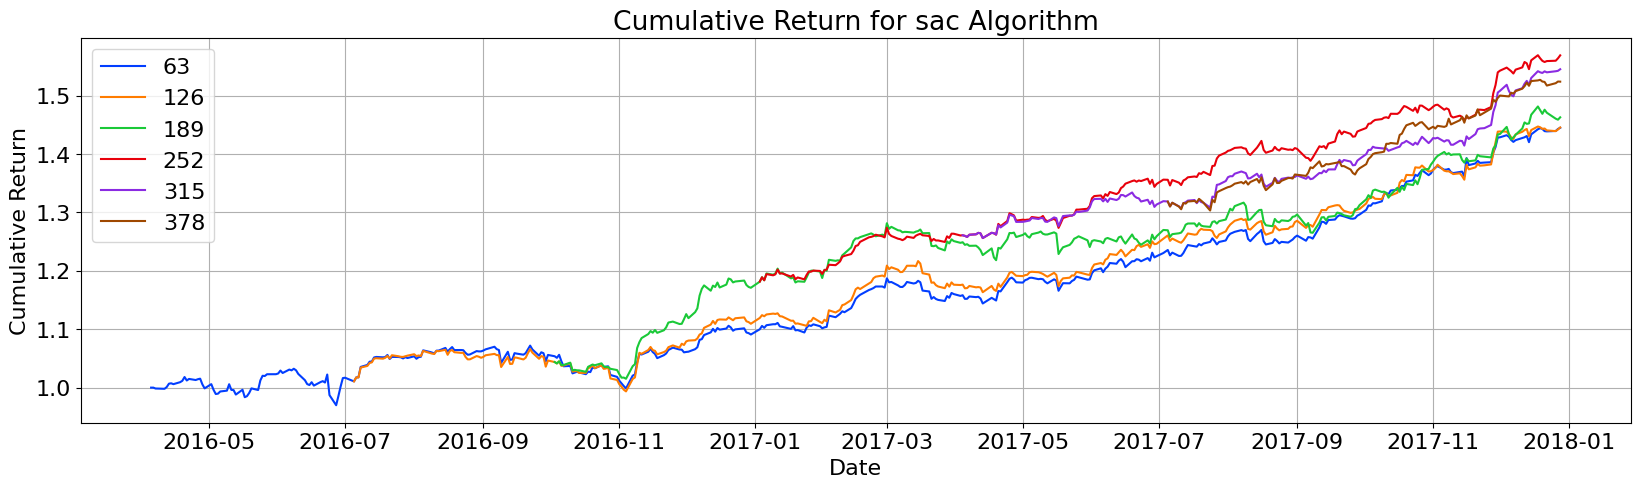

+---------------------+------------+------------+------------+------------+------------+------------+
|                     |         63 |        125 |        189 |        252 |        315 |        378 |
+=====================+============+============+============+============+============+============+
| Annual return       |  0.235216  |  0.235467  |  0.243971  |  0.294992  |  0.283687  |  0.273528  |
| Cumulative returns  |  0.444847  |  0.445359  |  0.462734  |  0.568832  |  0.54505   |  0.523813  |
| Annual volatility   |  0.0938861 |  0.0959326 |  0.102923  |  0.0913481 |  0.0914975 |  0.0910084 |
| Sharpe ratio        |  2.30295   |  2.25797   |  2.17825   |  2.88336   |  2.78265   |  2.70955   |
| Calmar ratio        |  3.43939   |  3.46101   |  4.03373   |  4.8773    |  4.69038   |  4.52243   |
| Stability           |  0.938607  |  0.948831  |  0.93182   |  0.967314  |  0.960199  |  0.962189  |
| Max drawdown        | -0.0683887 | -0.0680342 | -0.0604827 | -0.0604827 | -0.060

In [55]:
sac = model_parameters(model_name="sac", kwargs=model_kwargs.SAC_KWARGS, steps = model_kwargs.TIMESTEPS_DICT["sac"], data = data_85, data_retention_level = "85")

test_retrain = one_algorithm_test(trade_start = '2016-01-01',
                                       trade_end = '2018-01-01',
                                       rebalance_time = 63, # 126
                                       algorithm = sac,
                                       env_type = "retrain")

test_results = test_retrain.run()
%matplotlib inline
test_retrain.evaluate()
x = test_retrain.stats()
print(tabulate(x, ["63", "125", "189", "252", "315", "378"], tablefmt="outline"))

#### A2C

Training_63
Training_126
Training_189
Training_252
Training_315
Training_378


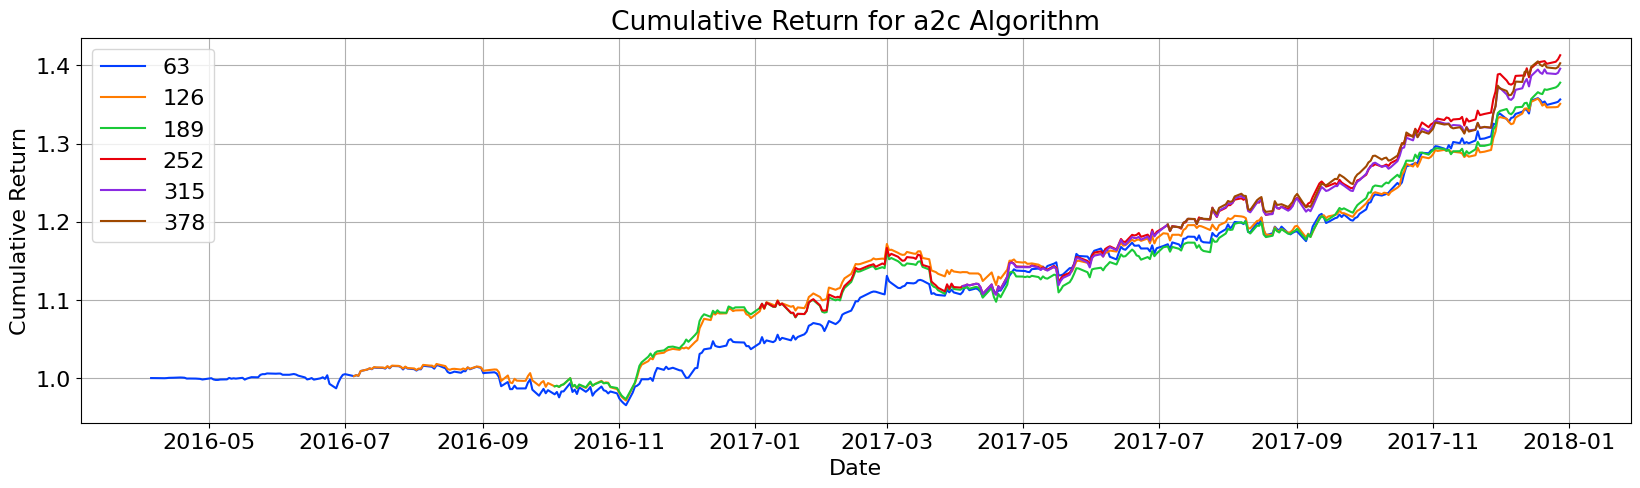

+---------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|                     |          63 |         125 |         189 |         252 |         315 |         378 |
+=====================+=============+=============+=============+=============+=============+=============+
| Annual return       |  0.191296   |  0.18846    |  0.202098   |  0.219584   |  0.211051   |  0.214502   |
| Cumulative returns  |  0.356536   |  0.350914   |  0.378035   |  0.413143   |  0.395963   |  0.4029     |
| Annual volatility   |  0.0730014  |  0.0672603  |  0.073491   |  0.0744238  |  0.0762481  |  0.0763668  |
| Sharpe ratio        |  2.44046    |  2.60727    |  2.5479     |  2.7115     |  2.55606    |  2.58957    |
| Calmar ratio        |  3.80211    |  4.09465    |  3.62778    |  4.30555    |  4.10493    |  4.17205    |
| Stability           |  0.896333   |  0.917256   |  0.906665   |  0.915626   |  0.918631   |  0.918195   |
| Max drawdown        | -0.0

In [53]:
a2c = model_parameters(model_name="a2c", kwargs=model_kwargs.A2C_KWARGS, steps = model_kwargs.TIMESTEPS_DICT["a2c"], data = data_85, data_retention_level = "85")
test_retrain = one_algorithm_test(trade_start = '2016-01-01',
                                       trade_end = '2018-01-01',
                                       rebalance_time = 63, # 126
                                       algorithm = a2c,
                                       env_type = "retrain")

test_results = test_retrain.run()
%matplotlib inline
test_retrain.evaluate()
x = test_retrain.stats()
print(tabulate(x, ["63", "125", "189", "252", "315", "378"], tablefmt="outline"))

#### PPO

Training_63
Training_126
Training_189
Training_252
Training_315
Training_378


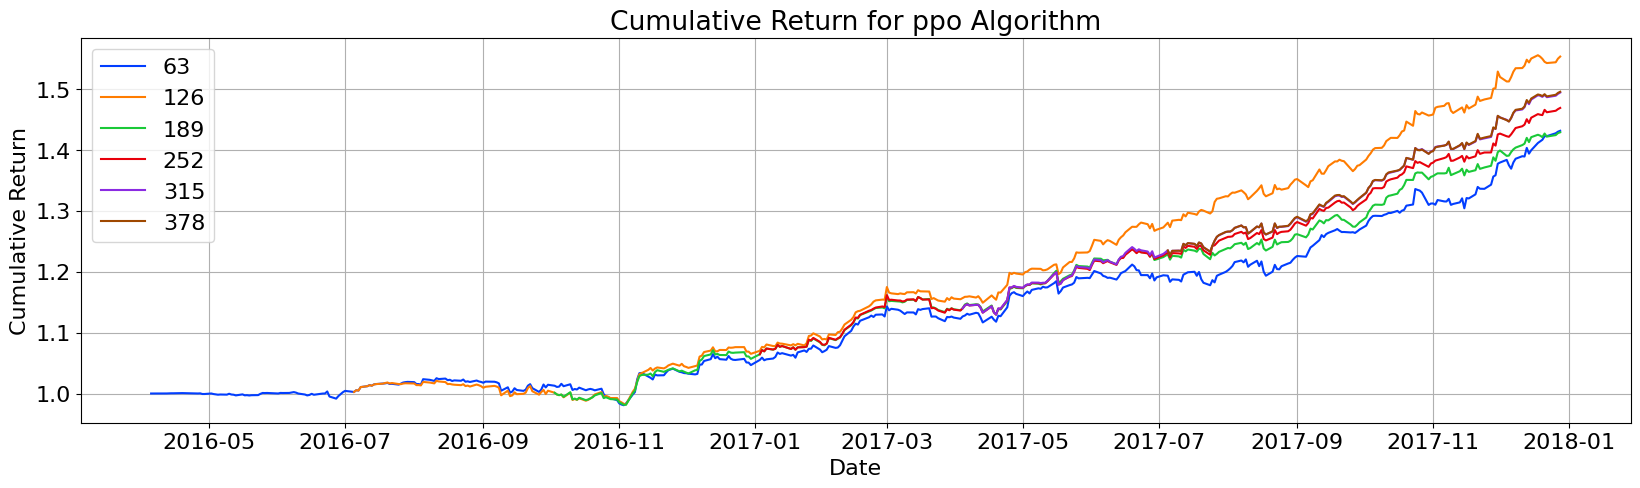

+---------------------+-------------+-------------+-------------+-------------+------------+-------------+
|                     |          63 |         125 |         189 |         252 |        315 |         378 |
+=====================+=============+=============+=============+=============+============+=============+
| Annual return       |  0.228682   |  0.287708   |  0.227473   |  0.247086   |  0.259345  |  0.259996   |
| Cumulative returns  |  0.43156    |  0.553491   |  0.429105   |  0.469122   |  0.494372  |  0.495717   |
| Annual volatility   |  0.0722952  |  0.0685915  |  0.0676153  |  0.0671941  |  0.0681829 |  0.0683051  |
| Sharpe ratio        |  2.89231    |  3.73091    |  3.07307    |  3.32856    |  3.42519   |  3.42677    |
| Calmar ratio        |  5.2857     |  7.56691    |  5.89201    |  6.40005    |  6.71758   |  6.73444    |
| Stability           |  0.921868   |  0.924933   |  0.931212   |  0.92708    |  0.921764  |  0.921629   |
| Max drawdown        | -0.0432643  |

In [54]:
ppo = model_parameters(model_name="ppo", kwargs=model_kwargs.PPO_KWARGS, steps = model_kwargs.TIMESTEPS_DICT["ppo"], data = data_85, data_retention_level = "85")

test_retrain = one_algorithm_test(trade_start = '2016-01-01',
                                       trade_end = '2018-01-01',
                                       rebalance_time = 63, # 126
                                       algorithm = ppo,
                                       env_type = "retrain")

test_results = test_retrain.run()
%matplotlib inline
test_retrain.evaluate()
x = test_retrain.stats()
print(tabulate(x, ["63", "125", "189", "252", "315", "378"], tablefmt="outline"))

### Regime Switching Strategy 

In [281]:
data_85 = pd.read_csv("../Data/Datasets/PCA_datasets/Dow_Pca_0.85_current.csv", index_col=0).fillna(0)
data_99 = pd.read_csv("../Data/Datasets/PCA_datasets/Dow_Pca_0.99_current.csv", index_col=0).fillna(0)


a2c_85 = model_parameters(model_name="a2c", kwargs=deepcopy(model_kwargs.A2C_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["a2c"], data = data_85, data_retention_level = "85")
a2c_99 = model_parameters(model_name="a2c", kwargs=deepcopy(model_kwargs.A2C_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["a2c"], data = data_99, data_retention_level = "99")

ddpg_85 = model_parameters(model_name="ddpg", kwargs=deepcopy(model_kwargs.DDPG_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ddpg"], data = data_85, data_retention_level = "85")
ddpg_99 = model_parameters(model_name="ddpg", kwargs=deepcopy(model_kwargs.DDPG_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ddpg"], data = data_99, data_retention_level = "99")

ppo_85 = model_parameters(model_name="ppo", kwargs=deepcopy(model_kwargs.PPO_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ppo"], data = data_85, data_retention_level = "85")
ppo_99 = model_parameters(model_name="ppo", kwargs=deepcopy(model_kwargs.PPO_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ppo"], data = data_99, data_retention_level = "99")

td3_85 = model_parameters(model_name="td3", kwargs=deepcopy(model_kwargs.TD3_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["td3"], data = data_85, data_retention_level = "85") 
td3_99 = model_parameters(model_name="td3", kwargs=deepcopy(model_kwargs.TD3_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["td3"], data = data_99, data_retention_level = "99") 

sac_85 = model_parameters(model_name="sac", kwargs=deepcopy(model_kwargs.SAC_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["sac"], data = data_85, data_retention_level = "85") 
sac_99 = model_parameters(model_name="sac", kwargs=deepcopy(model_kwargs.SAC_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["sac"], data = data_99, data_retention_level = "99") 

alg = [a2c_85, a2c_99, ppo_85, ppo_99, sac_85, sac_99, td3_85, td3_99, ddpg_85, ddpg_99]
alg_names = ["A2C 85", "A2C 99", "PPO 85", "PPO 99", "SAC 85", "SAC 99", "TD3 85", "TD3 99", "DDPG 85", "DDPG 99"]

Training from 2017 to 2019


In [ ]:
ensemble_strategy = ensemble_strategy2(trade_start = '2017-01-01',
                                       trade_end = '2020-01-06',
                                       rebalance_time = 63,
                                       algorithms = alg)

summery = ensemble_strategy.run_strategy()

Training from 2020 to 2022

In [256]:
date = "2020-01-06"

account_value = pd.read_csv("ensemble_results/results/account_value.csv")
account_value = account_value.drop(columns = ['Unnamed: 0'])
stock_costs = data_85[data_85["date"] == date]["close"].array

action_list = pd.read_csv("ensemble_results/results/actions.csv")
stocks_held = [0] * 29
stocks_held, bal = get_account_based_on_actions(action_list, stock_costs, account_value, date, stocks_held)

acc = account(bal, 29, 30, stocks_held)

In [ ]:
ensemble_strategy_2 = ensemble_strategy2(trade_start = '2020-01-07',
                                       trade_end = '2022-01-01',
                                       rebalance_time = 63,
                                       algorithms = alg,
                                       account_in = acc)

summery = ensemble_strategy_2.run_strategy()

In [265]:
account_value_2 = pd.read_csv("ensemble_results/results/account_value3.csv")
account_value_2 = account_value_2.drop(columns = ['Unnamed: 0'])
test_account_value = pd.concat([account_value, account_value_2]).reset_index(drop=True)

In [240]:
iter = [126, 189, 252, 315, 378, 441, 504, 567, 630, 756, 819, 882, 945, 1008, 1071, 1134, 1260, 1323, 1386, 1449]
summery = pd.concat([pd.read_csv("ensemble_results/results/summery.csv")[:-4].reset_index(drop=True), pd.read_csv("ensemble_results/results/summery3.csv").reset_index(drop=True)]).reset_index(drop=True)
summery = summery.drop(columns = ['Unnamed: 0'])
summery = summery[:-4]
summery["Iter"] = iter


### Base Models

In [282]:
data = pd.read_csv("../Data/Datasets/PCA_datasets/Dow_Pca_0.85.csv", index_col=0)
base_algorithms = train_base_models(start_trade = '2017-01-01',
                                       end_trade = '2022-01-01',
                                       algorithms = alg)

base_algorithms_results = base_algorithms.run_base_models()

Training a2c_85
Training a2c_99
Training ppo_85
Training ppo_99
Training sac_85
Training sac_99
Training td3_85
Training td3_99
Training ddpg_85
Training ddpg_99


## Evaluation

In [300]:
df = deepcopy(test_account_value)
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])
bt_returns = get_daily_return(df, value_col_name="account_value")

DJI_value = YahooDownloader(
        start_date=df.loc[0,'date'], 
        end_date=df.loc[len(df)-1,'date'], 
        ticker_list=['^DJI']
    ).fetch_data()
DJI_value["date"] = pd.to_datetime(DJI_value["date"], format="%Y-%m-%d")
DJI_value = pd.merge(df[["date"]], DJI_value, how="left", on="date")
DJI_value = DJI_value.fillna(method="ffill").fillna(method="bfill")
benchmark_rets = get_daily_return(DJI_value, value_col_name="close")
benchmark_rets.name = "DJI"

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1258, 8)


### Important Performance Statistics

#### Risk-Adjusted Return
The risk-adjusted return is an essential metric of any strategy. Risk-adjusted returns allow us to judge returns streams that have different individual volatilities by providing an avenue for meaningful comparison. There are different measures of risk-adjusted returns but one of the most popular is the Sharpe ratio.

In [301]:
print("The Sharpe Ratio of the backtest is: ", empyrical.sharpe_ratio(bt_returns))

The Sharpe Ratio of the backtest is:  1.0589376302506737


#### Market Beta
The market beta of an algorithm is the exposure of that strategy to the broader market. For instance, a market beta of 1 would mean that you're buying the the market, while a beta of −1 means that you are shorting the market. Any beta within this range signifies reduced market influence, while any beta outside this range signifies increased market influence.

In [302]:
print("The market beta of the backtest is: ", empyrical.beta(bt_returns,benchmark_rets))

The market beta of the backtest is:  0.3740615919660544


A strategy with no or little exposure to the market is market neutral. To institutional investors, market neutral strategies are very attractive. After all, if the investors want a strategy which is highly exposed to the market, they could simply buy an ETF or an index fund.

#### Drawdowns

A drawdown is the 'peak to trough decline' of an investment strategy. Intuitively speaking, it refers to the losses the strategy has experienced from the base amount of capital which it had at the peak. For instance, in the 2008 Financial Crisis, the market drawdown was over 50% from the peak in 2007 to the trough in 2009.

In [303]:
print("The maxmimum drawdown of the backtest is: ", empyrical.max_drawdown(bt_returns))

The maxmimum drawdown of the backtest is:  -0.17325333775203233


This is another measure of the financial risk of an algorithm. If the net drawdown of a strategy is very significant, this generally means that the volatility of the algorithm is more significant. Good strategies try to limit drawdowns. A good benchmark is to have a maximum drawdown of less than 20%.

In [304]:
pf.show_perf_stats(returns=bt_returns,
                   factor_returns=benchmark_rets)

Start date,2017-01-03
End date,2021-12-31
Total months,59
,Backtest
Annual return,14.515%
Cumulative returns,96.72%
Annual volatility,13.707%
Sharpe ratio,1.06
Calmar ratio,0.84
Stability,0.77
Max drawdown,-17.325%


### Return Plots

#### Helper Functions

In [305]:
def states(account_value_base, account_value_ens, value_col_name="account_value"):
    data = [
        ["Annual return"],
        ["Cumulative returns"],
        ["Annual volatility"],
        ["Sharpe ratio"],
        ["Calmar ratio"],
        ["Stability"],
        ["Max drawdown"],
        ["Omega ratio"],
        ["Sortino ratio"],
        ["Tail ratio"],
        ["Daily value at risk"]
    ]
    account_value_base_copy = deepcopy(account_value_base)
    account_value_base_copy.append(account_value_ens)

    for x in account_value_base_copy:
        dr_test = get_daily_return(x, value_col_name=value_col_name)
        perf_stats_all = timeseries.perf_stats(
            returns=dr_test,
            positions=None,
            transactions=None,
            turnover_denom="AGB",
        )

        counter = 0
        for index, row in perf_stats_all.iteritems():
            if index != "Skew" and index != "Kurtosis":
                data[counter].append(row)
                counter += 1
        
    return data

In [306]:
import colorcet as cc

def plot_cumulative_returns(returns, factor_returns, summary, algorithms, base_results = None):
    cum_rets = ep.cum_returns(returns, 1.0)
    colors = sns.color_palette("bright")
    

    cum_factor_returns = ep.cum_returns(factor_returns[cum_rets.index], 1.0)
    plt.plot(cum_factor_returns.index, cum_factor_returns.values, label = "DOW", color = 'black')
    
    alg_pos = {}
    counter = 0
    algorithm_results = []
    for alg in range(len(algorithms)):
        mod = (algorithms[alg].model_name + "_" + algorithms[alg].data_retention_level)
        if mod not in alg_pos:
            alg_pos[mod] = counter
            counter += 1
            algorithm_results.append([])
    labels = [True] * len(alg_pos)

    counter = 0
    breaks = False

    unique_train_date = algorithms[0].data[
        (algorithms[0].data.date < '2017-01-01')
    ].date.unique()
    unique_trade_date = algorithms[0].data[
        (algorithms[0].data.date > '2017-01-01') & (algorithms[0].data.date <= '2022-01-04')
    ].date.unique()
    
    unique_trade_date = np.insert(unique_trade_date, 0, unique_train_date[-ensemble_strategy_2.rebalance_time:])
    
    for i in range(ensemble_strategy_2.rebalance_time, len(unique_trade_date)+ensemble_strategy_2.rebalance_time, ensemble_strategy_2.rebalance_time):
        start = unique_trade_date[i]

        if i + ensemble_strategy_2.rebalance_time < len(unique_trade_date)-ensemble_strategy_2.rebalance_time:
            end = unique_trade_date[i+ensemble_strategy_2.rebalance_time]
        else:
            end = cum_rets.index[-1].strftime('%Y-%m-%d')
            breaks = True

        model = summary["Model Used"].iloc[counter]
        if labels[alg_pos[model]] == True:
            label = model.upper()
            labels[alg_pos[model]] = False
        else:
            label = None
        
        plt.plot(cum_rets[start:end].index, cum_rets[start:end].values, color = colors[alg_pos[model]], label = label)

        counter += 1
        if breaks == True:
            break
    
    if base_results != None:
        counter = 0
        for x in base_results:
            cum_base_rets = ep.cum_returns(x, 1.0)
            # print(alg_pos.keys()[0])
            plt.plot(cum_base_rets.index, cum_base_rets.values, color = colors[alg_pos[list(alg_pos.keys())[counter]]])
            counter += 1

    plt.grid()
    plt.ylabel('Cumulative returns')
    plt.xlabel('Date')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=False, shadow=False, ncol=(len(summary["Model Used"].unique())+1)/2)

def compare_alg(results, base_results, base_labels):
    plt.rcParams["figure.figsize"] = (32,10)
    counter = 0
    colours = sns.color_palette(cc.glasbey, n_colors=25)
    fig = plt.figure()
    ax = plt.subplot(111)

    for res in base_results:
        cum_base_results = ep.cum_returns(res, 1.0)
        plt.plot(cum_base_results.index, cum_base_results.values, color = colours[counter], label = base_labels[counter])
        counter += 1

    cum_results = ep.cum_returns(results, 1.0)
    ax.plot(cum_results.index, cum_results.values, color = colours[counter], label = "Regime Switching")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])

    ax.set_ylabel("Cumulative Return")
    ax.set_xlabel("Date")
    ax.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=True, ncol=5)
    plt.show()


#### Results 

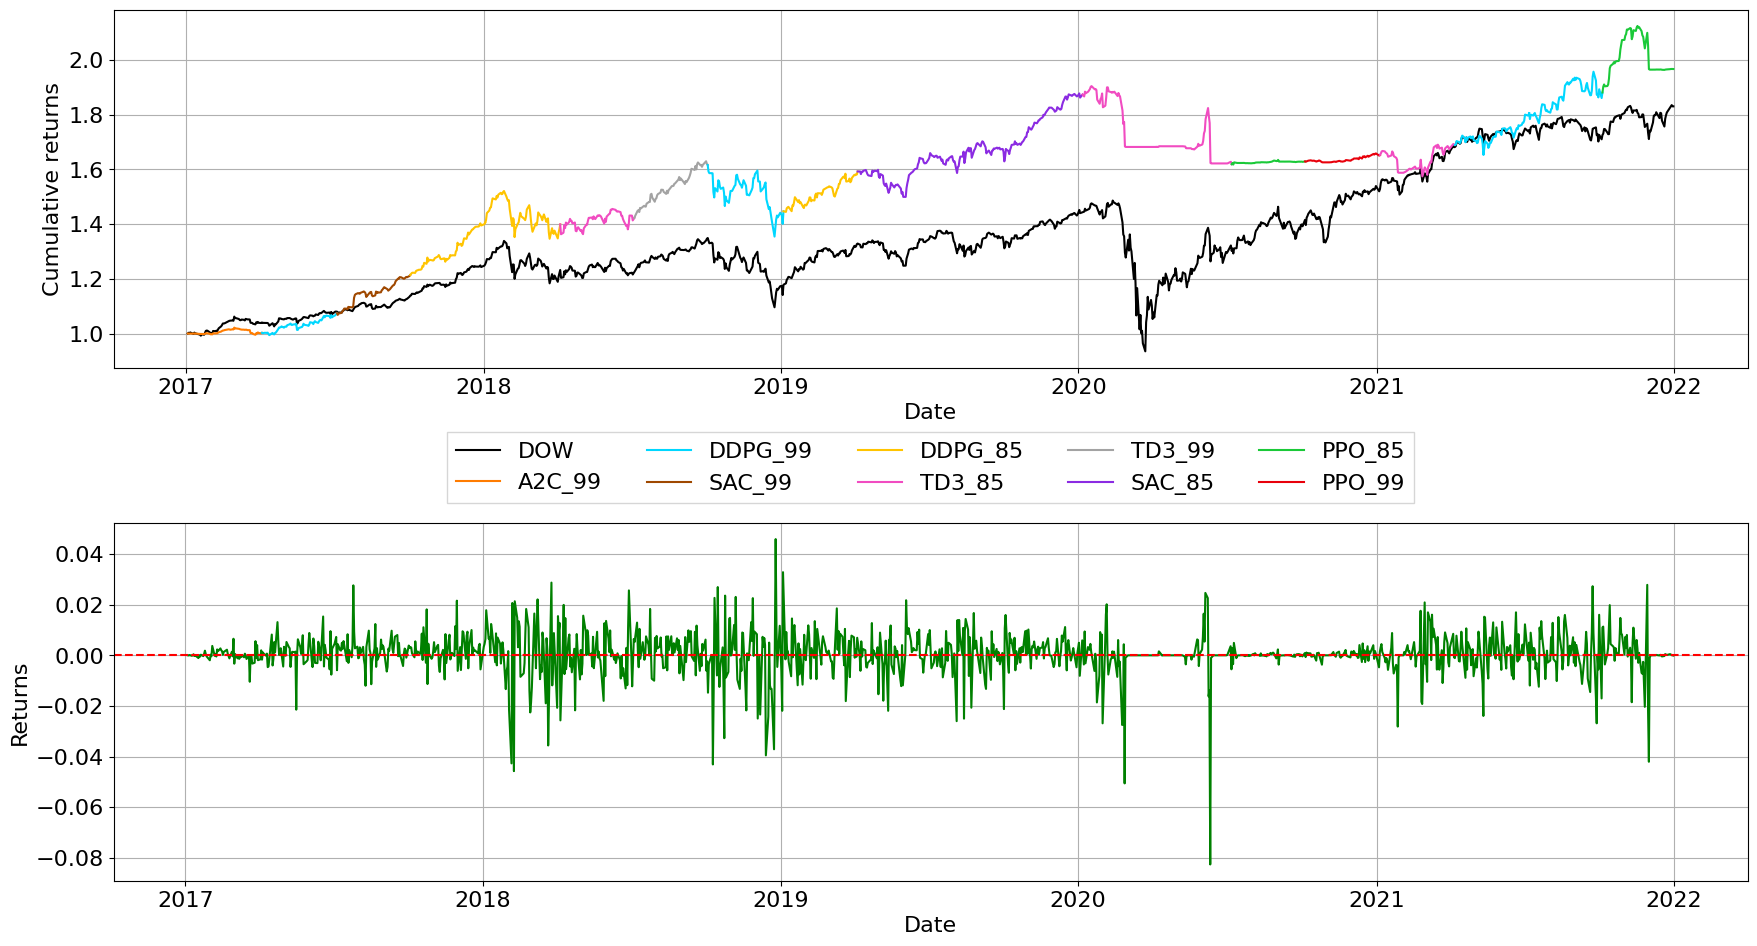

In [307]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,10)
# Cumulative Returns
plt.subplot(2,1,1)
# rolling_returns(returns = bt_returns, 
#                 factor_returns = benchmark_rets)
plot_cumulative_returns(bt_returns, benchmark_rets, summery, alg)

# Daily, Non-Cumulative Returns
plt.subplot(2,1,2)
pf.plotting.plot_returns(bt_returns)
plt.tight_layout()
plt.xticks(rotation = 0, ha = "center")
plt.xlabel('Date')
plt.axhline(y = 0.0, color = 'r', linestyle = '--')
plt.grid()

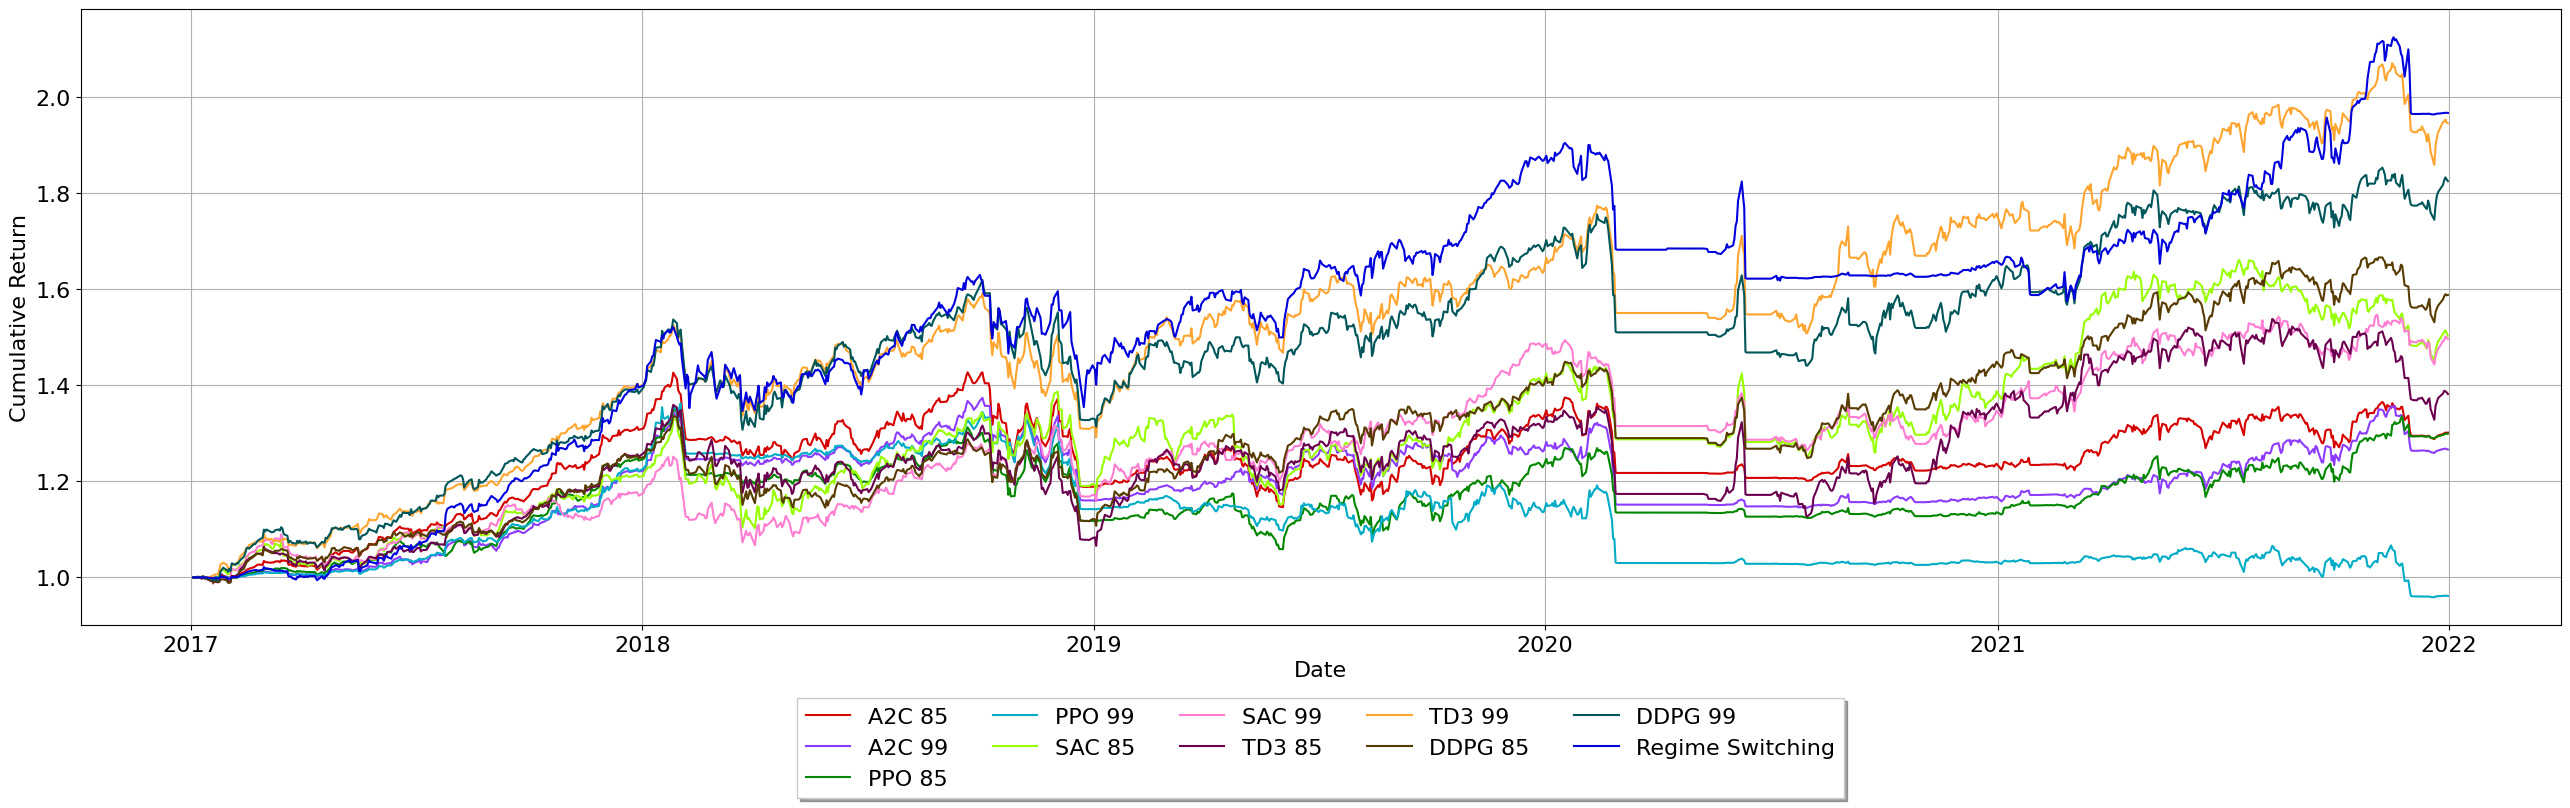

+---------------------+------------+------------+------------+-------------+------------+------------+------------+------------+------------+------------+--------------------+
|                     |     A2C 85 |     A2C 99 |     PPO 85 |      PPO 99 |     SAC 85 |     SAC 99 |     TD3 85 |     TD3 99 |    DDPG 85 |    DDPG 99 |   Regiem Switching |
+=====================+============+============+============+=============+============+============+============+============+============+============+====================+
| Annual return       |  0.0541809 |  0.0484    |  0.0538353 | -0.00781618 |  0.084986  |  0.0840368 |  0.066881  |  0.142518  |  0.0970231 |  0.127967  |           0.145152 |
| Cumulative returns  |  0.301622  |  0.26635   |  0.299491  | -0.0384448  |  0.503073  |  0.496515  |  0.381873  |  0.945747  |  0.588252  |  0.825049  |           0.9672   |
| Annual volatility   |  0.109358  |  0.101521  |  0.0999539 |  0.102071   |  0.142511  |  0.117394  |  0.144705  |  0.1

In [308]:
base_results = []
for x in base_algorithms_results:
    df = deepcopy(x)
    df["date"] = pd.to_datetime(df["date"])
    base_results.append(get_daily_return(df, value_col_name="account_value"))

compare_alg(bt_returns, base_results, alg_names)
alg_stats = states(base_algorithms_results, test_account_value)
print(tabulate(alg_stats, (alg_names + ["Regiem Switching"]), tablefmt="outline"))

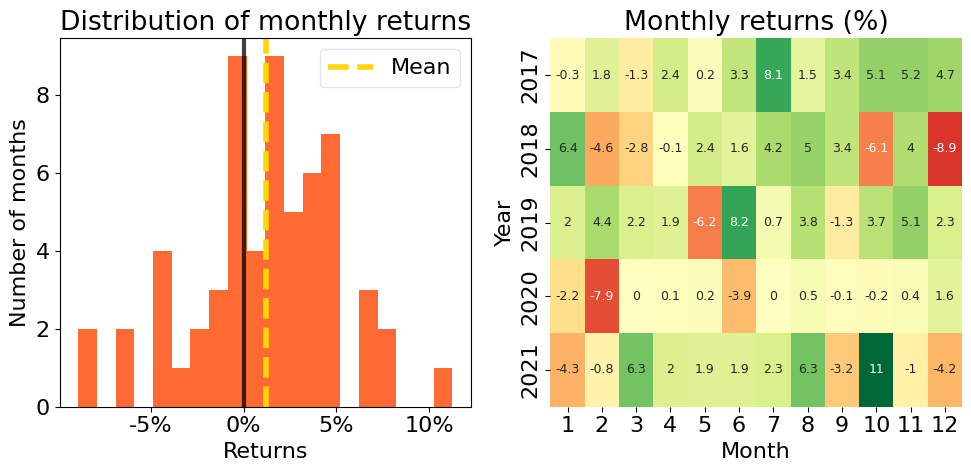

In [250]:
fig = plt.figure(1)
plt.subplot(1,2,1)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,2,2)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(10,5)
fig.tight_layout() 

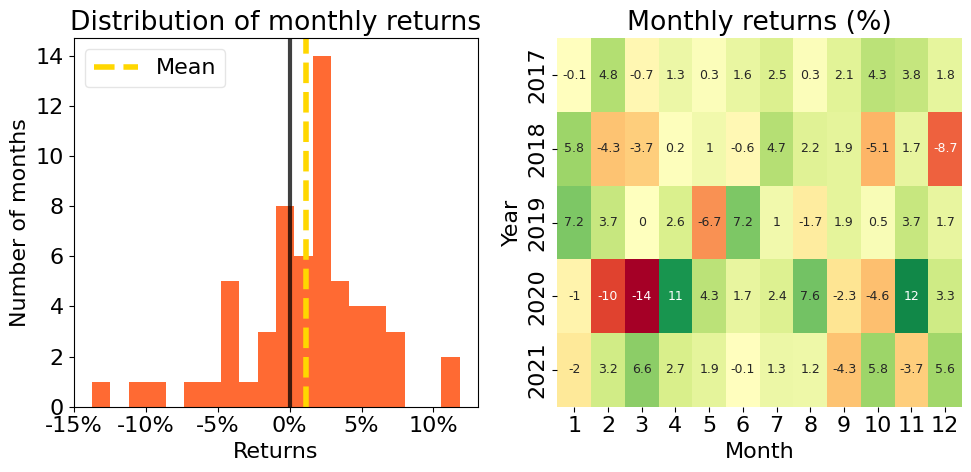

In [251]:
%matplotlib inline
fig = plt.figure(1)
plt.subplot(1,2,1)
pf.plot_monthly_returns_dist(benchmark_rets)
plt.subplot(1,2,2)
pf.plot_monthly_returns_heatmap(benchmark_rets)
plt.tight_layout()
fig.set_size_inches(10,5)
fig.tight_layout() 
plt.show()

### Drawdown Plots

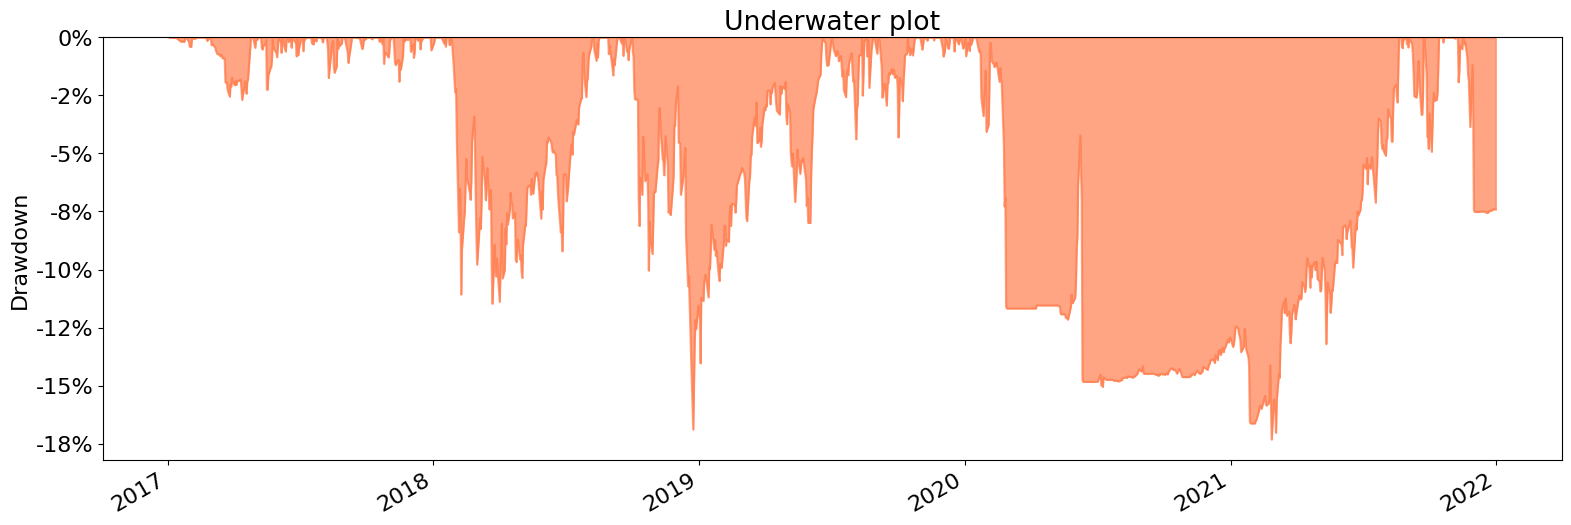

In [309]:
plt.rcParams["figure.figsize"] = (16,10)
# plt.subplot(2,1,1)
# pf.plot_drawdown_periods(bt_returns)
plt.subplot(2,1,2)
pf.plot_drawdown_underwater(bt_returns)
plt.tight_layout()

In [ ]:
pf.plot_gross_leverage(bt_returns, bt_positions)

NameError: name 'bt_positions' is not defined

### Position Plots

In [ ]:
action_amounts = pd.DataFrame([
    'date'
])

In [ ]:
starting_counts = [0] * (len(ensemble_strategy.actions.columns)+1)
starting_counts[-1] = 1000000
for index, row in ensemble_strategy.actions.iterrows():
    counter = 0
    for ticker, amount in row.iteritems():
        starting_counts[counter] += amount
        starting_counts[-1] -= (amount * (data[(data['tic'] == ticker) & (data['date'] == index)]['open'].values[0]))
        counter += 1
    action_amounts.loc[index] = starting_counts


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
pos_percent = pf.pos.get_percent_alloc(action_amounts)
pf.plotting.show_and_plot_top_positions(bt_returns, pos_percent)